In this notebook, we compare the performance of SGD and DCASGD for several datasets after some hyperparameter tuning


In [ ]:
!which nvcc
!nvcc --version

/usr/local/cuda/bin/nvcc
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# !pip install requests jupyter
!pip install mxnet-cu110
from google.colab import drive
drive.mount('/content/gdrive')
import os
import mxnet as mx
from mxnet import gluon
from mxnet import gluon, optimizer
from mxnet.gluon.model_zoo import vision

# Uncomment the following line if matplotlib is not installed.
# !pip install matplotlib

from mxnet import nd, gluon, init, autograd,gpu
from mxnet.gluon import data as gdata, utils
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from mxnet import image

from IPython import display
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import math
import numpy as np
import copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 327.3 MB 6.7 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Mounted at /content/gdrive


In [ ]:
# Simple network to do some tests if you prefer replacing the ResNet18 that we are using thereafter
net = nn.Sequential()
net.add(nn.Conv2D(channels=32, kernel_size=6, activation='relu'),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.Conv2D(channels=32, kernel_size=6, activation='relu'),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.Dense(10),
        nn.BatchNorm(),
        nn.Activation('softrelu')
)

In [ ]:
def acc(output, label):
    """
    Accuracy

    Arguments:
        output {(batch, num_output) float32 ndarray} -- the labels computed by the model from the data
        label {(batch, ) int32 ndarray} -- actual labels

    Returns:
        float -- the accuracy
    """    
    # output: 
    # label: 
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

# Functions

In [ ]:
def train_model(optimizer_, train_data, valid_data, batch_size, epochs):
    """
    This is where the model does the training. 

    Arguments:
        optimizer_ {mxnet.optimizer} -- the optimizer we would like to use for the training. It must be already initialised with 
        the right parameters.
        train_data {NDArray} -- data used for the training
        valid_data {NDArray} -- data used for the validation
        batch_size {int} -- self-explanatory
        epochs {int} -- number of epochs to compute

    Returns:
        train_loss_ -- self-explanatory
        train_acc_ -- train accuracy 
        test_acc -- test accuracy
        time_per_epochs -- time per epoch computed (in seconds)
    """    
  trainer = gluon.Trainer(net.collect_params(), optimizer=optimizer_)
  test_acc = []
  train_loss_ = []
  train_acc_ = []
  time_per_epochs = []
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc, valid_acc = 0., 0., 0.
      tic = time.time()
      
      #for data, label in tqdm(train_data):
      for data, label in train_data:
          data = data.as_in_context(mx.gpu(0))
          label = label.as_in_context(mx.gpu(0))

          # forward + backward
          with autograd.record():
              output = net(data)
              loss = softmax_cross_entropy(output, label)
          
          loss.backward()
          # update parameters
          
          trainer.step(batch_size)
          # calculate training metrics
          train_loss += loss.mean().asscalar()
          train_acc += acc(output, label)
      
      # calculate validation accuracy
      for data, label in valid_data:
          data = data.as_in_context(mx.gpu(0))
          label = label.as_in_context(mx.gpu(0))
          valid_acc += acc(net(data), label)
      print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
              epoch, train_loss/len(train_data), train_acc/len(train_data),
              valid_acc/len(valid_data), time.time()-tic))
      train_loss_.append(train_loss/len(train_data))
      train_acc_.append(train_acc/len(train_data))
      test_acc.append(valid_acc/len(valid_data))
      time_per_epochs.append(time.time()-tic)

  return train_loss_, train_acc_, test_acc, time_per_epochs

In [ ]:
def comparison(epochs, train_data, valid_data,batch_size, net, lr,lamdas, momentum, num_workers, folder):
  """
  This function allows to compare the performance of a network between DC-ASGD and another optimizer of choice. 
  We added the required parameters for 
  DC-ASGD 

  Arguments:
      epochs {int} -- number of epochs to compute
      train_data {NDArray} -- data used for the training
      valid_data {NDArray} -- data used for the validation
      batch_size {int} -- self-explanatory
      net {mxnet network} -- the network to be trained
      lr {_type_} -- learning rate we apply to both algorithms
      lamdas {list, nparray} -- list of the delay compensation factors 
      momentum {float} -- momentum we apply to both algorithms
      num_workers {int} -- number of workers used for data preprocessing in the dataloader
      folder {str} -- name to save the figures
  """  
  transformer = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(0.13, 0.31)])

  train_data = gluon.data.DataLoader(train_data.transform_first(transformer), 
                                    batch_size=batch_size, 
                                    shuffle=True, 
                                    num_workers=num_workers) 
  valid_data = gluon.data.DataLoader( valid_data.transform_first(transformer),
                                      batch_size=batch_size,
                                      num_workers=num_workers)
  
  # DC-ASGD
  dcasgd_net = net

  all_results = []
  for l in lamdas : 
    dcasgd_net.collect_params().initialize(init=init.Xavier(),force_reinit=True, ctx=mx.gpu(0))
    optimizer_ = optimizer.DCASGD(momentum=momentum, lamda=l, learning_rate = lr)
    results_dcasgd = train_model(optimizer_, train_data, valid_data, batch_size, epochs)
    all_results.append(results_dcasgd)

  # SGD
  sgd_net = net
  sgd_net.collect_params().initialize(init=init.Xavier(),force_reinit=True, ctx=mx.gpu(0))
  optimizer_ = optimizer.SGD( wd=0.1, momentum=momentum, learning_rate = 0.03)
  results_sgd = train_model(optimizer_, train_data, valid_data, batch_size, epochs)

  results = np.array(all_results)


  plt.rcParams['figure.figsize'] = [24, 4]
  plt.rcParams.update({'font.size': 15})

  # Test ACC
  plt.subplot(1, 3, 1)
  for i, l in enumerate(lamdas) : 
    plt.scatter(range(epochs),results[:,2][i], label='DC-ASGD, lamda = ' + str(l))
  plt.plot(range(epochs),results_sgd[2], label='SGD')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (validation set)')
  plt.legend()
  plt.grid(True)


  # Time per epochs
  plt.subplot(1, 3, 2)
  for i, l in enumerate(lamdas) : 
    plt.scatter(range(epochs),results[:,3][i], label='DC-ASGD, lamda = ' + str(l))
  plt.plot(range(epochs),results_sgd[3], label='SGD')
  plt.xlabel('Epochs')
  plt.ylabel('Time per epochs')
  plt.legend()
  plt.grid(True)


  # Training loss
  plt.subplot(1, 3, 3)
  for i, l in enumerate(lamdas) : 
    plt.scatter(range(epochs),results[:,0][i], label='DC-ASGD, lamda = ' + str(l))
  plt.plot(range(epochs),results_sgd[0], label='SGD')
  plt.xlabel('Epochs')
  plt.ylabel('Training loss')
  plt.legend()
  plt.grid(True)

  plt.suptitle('Comparison between DCASGD and SGD for learning rate =' + str(lr))
  plt.show()
  plt.savefig("/content/gdrive/My Drive/" + folder + "learning_rate_" + str(lr)+"_epochs_" + str(epochs)+ ".png")


## Fashion MNIST

we start with the fashion MNSIT dataset

In [ ]:
  mnist_train = datasets.FashionMNIST(train=True)
  mnist_valid = datasets.FashionMNIST(train=False)

In [ ]:
# hyper-parameters
epochs = 10
batch_size = 256

# model
net = vision.resnet18_v1()

# criterion
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

lr_num_update = 3

### Find best learning rate for SGD

 10%|█         | 1/10 [00:35<05:18, 35.44s/it]

Epoch 0: loss 0.570, train acc 0.815, test acc 0.862, in 35.4 sec


 20%|██        | 2/10 [01:01<04:00, 30.07s/it]

Epoch 1: loss 0.309, train acc 0.885, test acc 0.886, in 26.3 sec


 30%|███       | 3/10 [01:29<03:21, 28.84s/it]

Epoch 2: loss 0.255, train acc 0.905, test acc 0.883, in 27.4 sec


 40%|████      | 4/10 [01:55<02:46, 27.78s/it]

Epoch 3: loss 0.217, train acc 0.919, test acc 0.896, in 26.1 sec


 50%|█████     | 5/10 [02:21<02:16, 27.38s/it]

Epoch 4: loss 0.188, train acc 0.928, test acc 0.901, in 26.7 sec


 60%|██████    | 6/10 [02:48<01:48, 27.08s/it]

Epoch 5: loss 0.163, train acc 0.938, test acc 0.910, in 26.5 sec


 70%|███████   | 7/10 [03:14<01:20, 26.89s/it]

Epoch 6: loss 0.139, train acc 0.947, test acc 0.909, in 26.5 sec


 80%|████████  | 8/10 [03:41<00:53, 26.63s/it]

Epoch 7: loss 0.122, train acc 0.954, test acc 0.907, in 26.1 sec


 90%|█████████ | 9/10 [04:07<00:26, 26.45s/it]

Epoch 8: loss 0.107, train acc 0.960, test acc 0.900, in 26.1 sec


100%|██████████| 10/10 [04:34<00:00, 27.48s/it]


Epoch 9: loss 0.092, train acc 0.966, test acc 0.900, in 27.7 sec


 10%|█         | 1/10 [00:26<03:55, 26.12s/it]

Epoch 0: loss 0.570, train acc 0.816, test acc 0.874, in 26.1 sec


 20%|██        | 2/10 [00:52<03:31, 26.39s/it]

Epoch 1: loss 0.308, train acc 0.886, test acc 0.890, in 26.6 sec


 30%|███       | 3/10 [01:19<03:04, 26.38s/it]

Epoch 2: loss 0.251, train acc 0.906, test acc 0.883, in 26.4 sec


 40%|████      | 4/10 [01:46<02:41, 26.95s/it]

Epoch 3: loss 0.215, train acc 0.918, test acc 0.892, in 27.8 sec


 50%|█████     | 5/10 [02:13<02:14, 26.84s/it]

Epoch 4: loss 0.181, train acc 0.931, test acc 0.898, in 26.6 sec


 60%|██████    | 6/10 [02:39<01:46, 26.66s/it]

Epoch 5: loss 0.162, train acc 0.938, test acc 0.897, in 26.3 sec


 70%|███████   | 7/10 [03:06<01:19, 26.51s/it]

Epoch 6: loss 0.140, train acc 0.947, test acc 0.901, in 26.2 sec


 80%|████████  | 8/10 [03:32<00:52, 26.49s/it]

Epoch 7: loss 0.123, train acc 0.953, test acc 0.906, in 26.5 sec


 90%|█████████ | 9/10 [03:58<00:26, 26.38s/it]

Epoch 8: loss 0.109, train acc 0.959, test acc 0.906, in 26.1 sec


100%|██████████| 10/10 [04:25<00:00, 26.50s/it]


Epoch 9: loss 0.095, train acc 0.965, test acc 0.910, in 26.4 sec


 10%|█         | 1/10 [00:28<04:15, 28.33s/it]

Epoch 0: loss 0.555, train acc 0.819, test acc 0.863, in 28.3 sec


 20%|██        | 2/10 [00:54<03:37, 27.15s/it]

Epoch 1: loss 0.312, train acc 0.884, test acc 0.872, in 26.3 sec


 30%|███       | 3/10 [01:20<03:07, 26.75s/it]

Epoch 2: loss 0.255, train acc 0.904, test acc 0.897, in 26.3 sec


 40%|████      | 4/10 [01:47<02:40, 26.68s/it]

Epoch 3: loss 0.217, train acc 0.918, test acc 0.902, in 26.6 sec


 50%|█████     | 5/10 [02:13<02:12, 26.55s/it]

Epoch 4: loss 0.189, train acc 0.929, test acc 0.892, in 26.3 sec


 60%|██████    | 6/10 [02:40<01:46, 26.54s/it]

Epoch 5: loss 0.163, train acc 0.939, test acc 0.901, in 26.5 sec


 70%|███████   | 7/10 [03:06<01:19, 26.47s/it]

Epoch 6: loss 0.145, train acc 0.944, test acc 0.907, in 26.3 sec


 80%|████████  | 8/10 [03:35<00:54, 27.20s/it]

Epoch 7: loss 0.124, train acc 0.953, test acc 0.897, in 28.8 sec


 90%|█████████ | 9/10 [04:01<00:26, 26.97s/it]

Epoch 8: loss 0.108, train acc 0.959, test acc 0.906, in 26.4 sec


100%|██████████| 10/10 [04:28<00:00, 26.83s/it]


Epoch 9: loss 0.093, train acc 0.965, test acc 0.908, in 26.4 sec


 10%|█         | 1/10 [00:26<03:55, 26.22s/it]

Epoch 0: loss 0.557, train acc 0.820, test acc 0.867, in 26.2 sec


 20%|██        | 2/10 [00:52<03:29, 26.21s/it]

Epoch 1: loss 0.308, train acc 0.886, test acc 0.891, in 26.2 sec


 30%|███       | 3/10 [01:20<03:09, 27.03s/it]

Epoch 2: loss 0.252, train acc 0.906, test acc 0.897, in 28.0 sec


 40%|████      | 4/10 [01:46<02:40, 26.71s/it]

Epoch 3: loss 0.213, train acc 0.919, test acc 0.901, in 26.2 sec


 50%|█████     | 5/10 [02:12<02:12, 26.55s/it]

Epoch 4: loss 0.186, train acc 0.929, test acc 0.905, in 26.3 sec


 60%|██████    | 6/10 [02:39<01:45, 26.50s/it]

Epoch 5: loss 0.163, train acc 0.939, test acc 0.902, in 26.4 sec


 70%|███████   | 7/10 [03:05<01:19, 26.37s/it]

Epoch 6: loss 0.138, train acc 0.948, test acc 0.897, in 26.1 sec


 80%|████████  | 8/10 [03:31<00:52, 26.38s/it]

Epoch 7: loss 0.121, train acc 0.954, test acc 0.903, in 26.4 sec


 90%|█████████ | 9/10 [03:58<00:26, 26.38s/it]

Epoch 8: loss 0.107, train acc 0.959, test acc 0.907, in 26.4 sec


100%|██████████| 10/10 [04:24<00:00, 26.43s/it]


Epoch 9: loss 0.094, train acc 0.965, test acc 0.907, in 26.1 sec


 10%|█         | 1/10 [00:14<02:08, 14.24s/it]

Epoch 0: loss 0.567, train acc 0.824, test acc 0.779, in 14.2 sec


 20%|██        | 2/10 [00:28<01:52, 14.08s/it]

Epoch 1: loss 0.413, train acc 0.872, test acc 0.818, in 14.0 sec


 30%|███       | 3/10 [00:42<01:38, 14.08s/it]

Epoch 2: loss 0.500, train acc 0.874, test acc 0.858, in 14.1 sec


 40%|████      | 4/10 [00:56<01:24, 14.11s/it]

Epoch 3: loss 0.709, train acc 0.835, test acc 0.694, in 14.1 sec


 50%|█████     | 5/10 [01:10<01:10, 14.07s/it]

Epoch 4: loss 0.643, train acc 0.852, test acc 0.859, in 14.0 sec


 60%|██████    | 6/10 [01:24<00:56, 14.08s/it]

Epoch 5: loss 0.581, train acc 0.878, test acc 0.875, in 14.1 sec


 70%|███████   | 7/10 [01:39<00:43, 14.38s/it]

Epoch 6: loss 0.568, train acc 0.883, test acc 0.873, in 15.0 sec


 80%|████████  | 8/10 [01:54<00:29, 14.55s/it]

Epoch 7: loss 0.559, train acc 0.887, test acc 0.889, in 14.9 sec


 90%|█████████ | 9/10 [02:08<00:14, 14.44s/it]

Epoch 8: loss 0.551, train acc 0.889, test acc 0.890, in 14.2 sec


100%|██████████| 10/10 [02:22<00:00, 14.29s/it]

Epoch 9: loss 0.547, train acc 0.890, test acc 0.873, in 14.3 sec


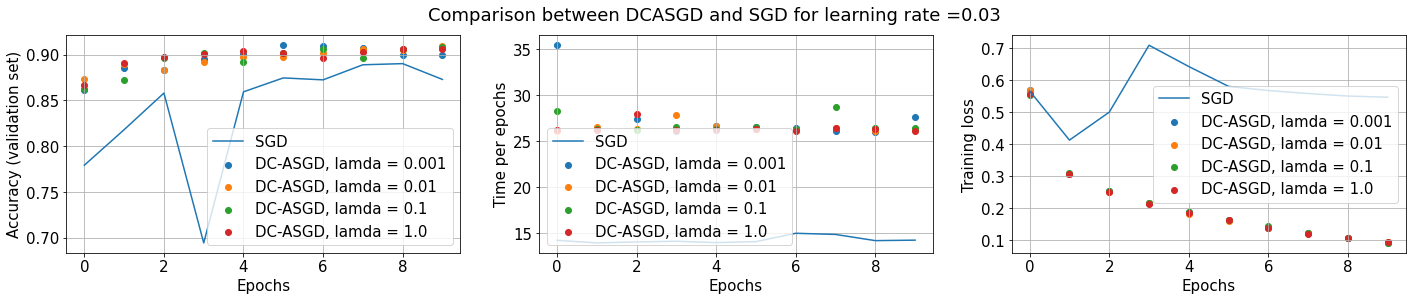

<Figure size 1728x288 with 0 Axes>

In [ ]:
comparison(10, mnist_train, mnist_valid, batch_size,net, lr = 0.03, lamdas = np.logspace(-3,0,4), momentum=0.0, num_workers=8, folder = "fMNIST")

## MNIST

In [ ]:
mnist_train = datasets.MNIST(train=True)
mnist_valid = datasets.MNIST(train=False)

In [ ]:
# hyper-parameters
epochs = 10
batch_size = 256

# model
net = vision.resnet18_v1()

lr_num_update = 3

 10%|█         | 1/10 [00:27<04:04, 27.17s/it]

Epoch 0: loss 0.184, train acc 0.958, test acc 0.984, in 27.2 sec


 20%|██        | 2/10 [00:53<03:35, 26.92s/it]

Epoch 1: loss 0.032, train acc 0.990, test acc 0.987, in 26.7 sec


 30%|███       | 3/10 [01:20<03:07, 26.82s/it]

Epoch 2: loss 0.013, train acc 0.996, test acc 0.990, in 26.7 sec


 40%|████      | 4/10 [01:47<02:40, 26.79s/it]

Epoch 3: loss 0.006, train acc 0.999, test acc 0.991, in 26.7 sec


 50%|█████     | 5/10 [02:14<02:13, 26.78s/it]

Epoch 4: loss 0.003, train acc 1.000, test acc 0.991, in 26.8 sec


 60%|██████    | 6/10 [02:40<01:46, 26.69s/it]

Epoch 5: loss 0.001, train acc 1.000, test acc 0.992, in 26.5 sec


 70%|███████   | 7/10 [03:06<01:19, 26.58s/it]

Epoch 6: loss 0.001, train acc 1.000, test acc 0.992, in 26.3 sec


 80%|████████  | 8/10 [03:33<00:53, 26.56s/it]

Epoch 7: loss 0.001, train acc 1.000, test acc 0.992, in 26.5 sec


 90%|█████████ | 9/10 [04:00<00:26, 26.57s/it]

Epoch 8: loss 0.000, train acc 1.000, test acc 0.992, in 26.6 sec


100%|██████████| 10/10 [04:28<00:00, 26.81s/it]


Epoch 9: loss 0.000, train acc 1.000, test acc 0.992, in 28.0 sec


 10%|█         | 1/10 [00:26<03:59, 26.59s/it]

Epoch 0: loss 0.187, train acc 0.959, test acc 0.987, in 26.6 sec


 20%|██        | 2/10 [00:53<03:33, 26.73s/it]

Epoch 1: loss 0.032, train acc 0.990, test acc 0.990, in 26.8 sec


 30%|███       | 3/10 [01:20<03:07, 26.78s/it]

Epoch 2: loss 0.014, train acc 0.996, test acc 0.990, in 26.8 sec


 40%|████      | 4/10 [01:46<02:40, 26.69s/it]

Epoch 3: loss 0.006, train acc 0.998, test acc 0.992, in 26.5 sec


 50%|█████     | 5/10 [02:13<02:13, 26.70s/it]

Epoch 4: loss 0.003, train acc 1.000, test acc 0.992, in 26.7 sec


 60%|██████    | 6/10 [02:40<01:46, 26.65s/it]

Epoch 5: loss 0.001, train acc 1.000, test acc 0.992, in 26.6 sec


 70%|███████   | 7/10 [03:06<01:19, 26.66s/it]

Epoch 6: loss 0.001, train acc 1.000, test acc 0.992, in 26.7 sec


 80%|████████  | 8/10 [03:33<00:53, 26.59s/it]

Epoch 7: loss 0.001, train acc 1.000, test acc 0.992, in 26.4 sec


 90%|█████████ | 9/10 [03:59<00:26, 26.48s/it]

Epoch 8: loss 0.000, train acc 1.000, test acc 0.993, in 26.2 sec


100%|██████████| 10/10 [04:25<00:00, 26.58s/it]


Epoch 9: loss 0.000, train acc 1.000, test acc 0.992, in 26.3 sec


 10%|█         | 1/10 [00:28<04:14, 28.33s/it]

Epoch 0: loss 0.178, train acc 0.959, test acc 0.984, in 28.3 sec


 20%|██        | 2/10 [00:54<03:37, 27.22s/it]

Epoch 1: loss 0.030, train acc 0.991, test acc 0.988, in 26.4 sec


 30%|███       | 3/10 [01:21<03:07, 26.80s/it]

Epoch 2: loss 0.013, train acc 0.996, test acc 0.989, in 26.3 sec


 40%|████      | 4/10 [01:47<02:40, 26.71s/it]

Epoch 3: loss 0.005, train acc 0.999, test acc 0.991, in 26.6 sec


 50%|█████     | 5/10 [02:14<02:13, 26.69s/it]

Epoch 4: loss 0.002, train acc 1.000, test acc 0.990, in 26.7 sec


 60%|██████    | 6/10 [02:41<01:46, 26.74s/it]

Epoch 5: loss 0.001, train acc 1.000, test acc 0.991, in 26.8 sec


 70%|███████   | 7/10 [03:07<01:19, 26.61s/it]

Epoch 6: loss 0.001, train acc 1.000, test acc 0.991, in 26.4 sec


 80%|████████  | 8/10 [03:33<00:53, 26.57s/it]

Epoch 7: loss 0.000, train acc 1.000, test acc 0.991, in 26.5 sec


 90%|█████████ | 9/10 [04:00<00:26, 26.52s/it]

Epoch 8: loss 0.000, train acc 1.000, test acc 0.991, in 26.4 sec


100%|██████████| 10/10 [04:26<00:00, 26.69s/it]


Epoch 9: loss 0.000, train acc 1.000, test acc 0.991, in 26.5 sec


 10%|█         | 1/10 [00:26<03:59, 26.60s/it]

Epoch 0: loss 0.180, train acc 0.959, test acc 0.983, in 26.6 sec


 20%|██        | 2/10 [00:53<03:32, 26.53s/it]

Epoch 1: loss 0.032, train acc 0.990, test acc 0.990, in 26.5 sec


 30%|███       | 3/10 [01:21<03:11, 27.35s/it]

Epoch 2: loss 0.015, train acc 0.996, test acc 0.989, in 28.3 sec


 40%|████      | 4/10 [01:47<02:41, 26.95s/it]

Epoch 3: loss 0.007, train acc 0.998, test acc 0.992, in 26.3 sec


 50%|█████     | 5/10 [02:14<02:13, 26.71s/it]

Epoch 4: loss 0.003, train acc 1.000, test acc 0.991, in 26.3 sec


 60%|██████    | 6/10 [02:40<01:46, 26.63s/it]

Epoch 5: loss 0.001, train acc 1.000, test acc 0.992, in 26.5 sec


 70%|███████   | 7/10 [03:06<01:19, 26.58s/it]

Epoch 6: loss 0.001, train acc 1.000, test acc 0.992, in 26.5 sec


 80%|████████  | 8/10 [03:33<00:53, 26.55s/it]

Epoch 7: loss 0.001, train acc 1.000, test acc 0.992, in 26.5 sec


 90%|█████████ | 9/10 [03:59<00:26, 26.49s/it]

Epoch 8: loss 0.000, train acc 1.000, test acc 0.992, in 26.4 sec


100%|██████████| 10/10 [04:26<00:00, 26.61s/it]


Epoch 9: loss 0.000, train acc 1.000, test acc 0.992, in 26.3 sec


 10%|█         | 1/10 [00:14<02:07, 14.19s/it]

Epoch 0: loss 0.199, train acc 0.960, test acc 0.982, in 14.2 sec


 20%|██        | 2/10 [00:28<01:53, 14.17s/it]

Epoch 1: loss 0.135, train acc 0.979, test acc 0.983, in 14.2 sec


 30%|███       | 3/10 [00:42<01:39, 14.26s/it]

Epoch 2: loss 0.224, train acc 0.979, test acc 0.976, in 14.4 sec


 40%|████      | 4/10 [00:56<01:25, 14.27s/it]

Epoch 3: loss 0.366, train acc 0.965, test acc 0.986, in 14.3 sec


 50%|█████     | 5/10 [01:11<01:11, 14.23s/it]

Epoch 4: loss 0.297, train acc 0.983, test acc 0.960, in 14.2 sec


 60%|██████    | 6/10 [01:25<00:56, 14.22s/it]

Epoch 5: loss 0.287, train acc 0.986, test acc 0.983, in 14.2 sec


 70%|███████   | 7/10 [01:39<00:42, 14.22s/it]

Epoch 6: loss 0.290, train acc 0.984, test acc 0.987, in 14.2 sec


 80%|████████  | 8/10 [01:53<00:28, 14.26s/it]

Epoch 7: loss 0.283, train acc 0.986, test acc 0.981, in 14.3 sec


 90%|█████████ | 9/10 [02:09<00:14, 14.79s/it]

Epoch 8: loss 0.335, train acc 0.972, test acc 0.969, in 15.9 sec


100%|██████████| 10/10 [02:24<00:00, 14.41s/it]

Epoch 9: loss 0.287, train acc 0.985, test acc 0.987, in 14.2 sec


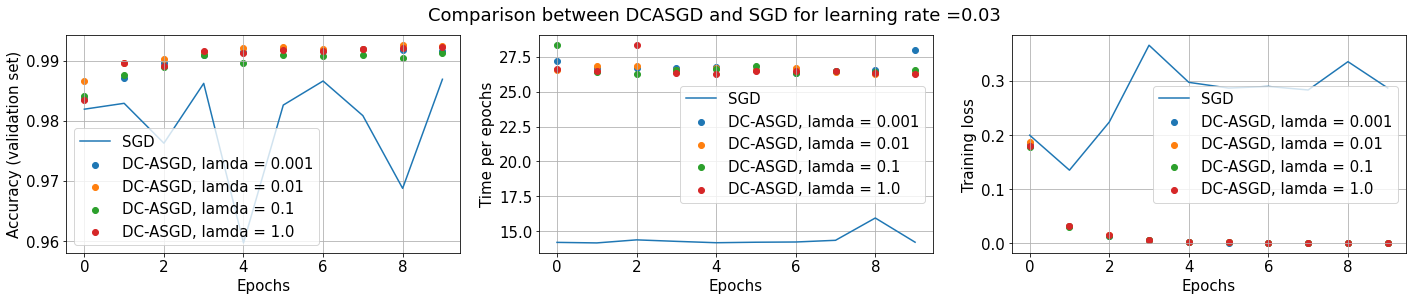

<Figure size 1728x288 with 0 Axes>

In [ ]:
comparison(epochs, mnist_train, mnist_valid, batch_size,net, lr = 0.03, lamdas = np.logspace(-3,0,4), momentum=0.0, num_workers=8, folder = "fMNIST")

## CIFAR100

In [ ]:
cifar_train = datasets.CIFAR100(train=True)
cifar_valid = datasets.CIFAR100(train=False)

In [ ]:
# hyper-parameters
epochs = 10
batch_size = 256

# model
net = vision.resnet18_v1()
net.collect_params().initialize(init=init.Xavier(),force_reinit=True, ctx=mx.gpu(0))

# criterion
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

lr_num_update = 3

 10%|█         | 1/10 [00:24<03:41, 24.60s/it]

Epoch 0: loss 2.554, train acc 0.268, test acc 0.328, in 24.6 sec


 20%|██        | 2/10 [00:47<03:11, 23.89s/it]

Epoch 1: loss 1.967, train acc 0.390, test acc 0.365, in 23.4 sec


 30%|███       | 3/10 [01:11<02:46, 23.81s/it]

Epoch 2: loss 1.733, train acc 0.459, test acc 0.401, in 23.7 sec


 40%|████      | 4/10 [01:35<02:21, 23.64s/it]

Epoch 3: loss 1.532, train acc 0.517, test acc 0.425, in 23.4 sec


 50%|█████     | 5/10 [01:58<01:58, 23.67s/it]

Epoch 4: loss 1.343, train acc 0.575, test acc 0.439, in 23.7 sec


 60%|██████    | 6/10 [02:22<01:35, 23.81s/it]

Epoch 5: loss 1.166, train acc 0.629, test acc 0.441, in 24.1 sec


 70%|███████   | 7/10 [02:46<01:11, 23.79s/it]

Epoch 6: loss 0.979, train acc 0.685, test acc 0.423, in 23.8 sec


 80%|████████  | 8/10 [03:09<00:47, 23.63s/it]

Epoch 7: loss 0.804, train acc 0.741, test acc 0.430, in 23.3 sec


 90%|█████████ | 9/10 [03:33<00:23, 23.53s/it]

Epoch 8: loss 0.652, train acc 0.788, test acc 0.397, in 23.3 sec


100%|██████████| 10/10 [03:56<00:00, 23.66s/it]


Epoch 9: loss 0.494, train acc 0.841, test acc 0.430, in 23.4 sec


 10%|█         | 1/10 [00:23<03:31, 23.51s/it]

Epoch 0: loss 2.553, train acc 0.269, test acc 0.323, in 23.5 sec


 20%|██        | 2/10 [00:47<03:11, 23.91s/it]

Epoch 1: loss 1.963, train acc 0.391, test acc 0.384, in 24.2 sec


 30%|███       | 3/10 [01:12<02:49, 24.17s/it]

Epoch 2: loss 1.718, train acc 0.464, test acc 0.405, in 24.5 sec


 40%|████      | 4/10 [01:35<02:23, 23.89s/it]

Epoch 3: loss 1.514, train acc 0.522, test acc 0.363, in 23.4 sec


 50%|█████     | 5/10 [01:59<01:58, 23.73s/it]

Epoch 4: loss 1.333, train acc 0.578, test acc 0.414, in 23.5 sec


 60%|██████    | 6/10 [02:22<01:34, 23.71s/it]

Epoch 5: loss 1.150, train acc 0.632, test acc 0.397, in 23.7 sec


 70%|███████   | 7/10 [02:46<01:10, 23.61s/it]

Epoch 6: loss 0.979, train acc 0.685, test acc 0.433, in 23.4 sec


 80%|████████  | 8/10 [03:09<00:47, 23.55s/it]

Epoch 7: loss 0.807, train acc 0.738, test acc 0.428, in 23.4 sec


 90%|█████████ | 9/10 [03:32<00:23, 23.50s/it]

Epoch 8: loss 0.643, train acc 0.792, test acc 0.434, in 23.4 sec


100%|██████████| 10/10 [03:56<00:00, 23.66s/it]


Epoch 9: loss 0.494, train acc 0.839, test acc 0.434, in 23.6 sec


 10%|█         | 1/10 [00:23<03:33, 23.71s/it]

Epoch 0: loss 2.531, train acc 0.272, test acc 0.302, in 23.7 sec


 20%|██        | 2/10 [00:47<03:08, 23.53s/it]

Epoch 1: loss 1.970, train acc 0.390, test acc 0.374, in 23.4 sec


 30%|███       | 3/10 [01:10<02:44, 23.50s/it]

Epoch 2: loss 1.735, train acc 0.456, test acc 0.356, in 23.5 sec


 40%|████      | 4/10 [01:33<02:20, 23.46s/it]

Epoch 3: loss 1.547, train acc 0.514, test acc 0.397, in 23.4 sec


 50%|█████     | 5/10 [01:57<01:57, 23.45s/it]

Epoch 4: loss 1.362, train acc 0.567, test acc 0.410, in 23.4 sec


 60%|██████    | 6/10 [02:22<01:36, 24.05s/it]

Epoch 5: loss 1.180, train acc 0.624, test acc 0.417, in 25.2 sec


 70%|███████   | 7/10 [02:46<01:11, 23.83s/it]

Epoch 6: loss 1.006, train acc 0.678, test acc 0.438, in 23.4 sec


 80%|████████  | 8/10 [03:09<00:47, 23.67s/it]

Epoch 7: loss 0.843, train acc 0.726, test acc 0.432, in 23.3 sec


 90%|█████████ | 9/10 [03:32<00:23, 23.65s/it]

Epoch 8: loss 0.689, train acc 0.775, test acc 0.430, in 23.6 sec


100%|██████████| 10/10 [03:56<00:00, 23.65s/it]


Epoch 9: loss 0.528, train acc 0.828, test acc 0.430, in 23.5 sec


 10%|█         | 1/10 [00:23<03:35, 23.92s/it]

Epoch 0: loss 2.547, train acc 0.268, test acc 0.314, in 23.9 sec


 20%|██        | 2/10 [00:47<03:09, 23.64s/it]

Epoch 1: loss 1.978, train acc 0.385, test acc 0.357, in 23.4 sec


 30%|███       | 3/10 [01:10<02:44, 23.53s/it]

Epoch 2: loss 1.748, train acc 0.453, test acc 0.395, in 23.4 sec


 40%|████      | 4/10 [01:34<02:20, 23.44s/it]

Epoch 3: loss 1.550, train acc 0.509, test acc 0.403, in 23.3 sec


 50%|█████     | 5/10 [01:57<01:57, 23.42s/it]

Epoch 4: loss 1.360, train acc 0.569, test acc 0.438, in 23.4 sec


 60%|██████    | 6/10 [02:20<01:33, 23.38s/it]

Epoch 5: loss 1.182, train acc 0.622, test acc 0.432, in 23.3 sec


 70%|███████   | 7/10 [02:44<01:10, 23.40s/it]

Epoch 6: loss 1.006, train acc 0.676, test acc 0.402, in 23.4 sec


 80%|████████  | 8/10 [03:07<00:46, 23.39s/it]

Epoch 7: loss 0.838, train acc 0.728, test acc 0.426, in 23.4 sec


 90%|█████████ | 9/10 [03:32<00:23, 23.94s/it]

Epoch 8: loss 0.671, train acc 0.783, test acc 0.431, in 25.1 sec


100%|██████████| 10/10 [03:56<00:00, 23.60s/it]


Epoch 9: loss 0.518, train acc 0.831, test acc 0.430, in 23.3 sec


 10%|█         | 1/10 [00:13<01:59, 13.31s/it]

Epoch 0: loss 2.548, train acc 0.278, test acc 0.272, in 13.3 sec


 20%|██        | 2/10 [00:26<01:46, 13.28s/it]

Epoch 1: loss 2.172, train acc 0.368, test acc 0.266, in 13.3 sec


 30%|███       | 3/10 [00:39<01:32, 13.21s/it]

Epoch 2: loss 2.241, train acc 0.392, test acc 0.235, in 13.1 sec


 40%|████      | 4/10 [00:52<01:19, 13.21s/it]

Epoch 3: loss 2.325, train acc 0.405, test acc 0.281, in 13.2 sec


 50%|█████     | 5/10 [01:06<01:06, 13.28s/it]

Epoch 4: loss 2.295, train acc 0.422, test acc 0.305, in 13.4 sec


 60%|██████    | 6/10 [01:19<00:52, 13.24s/it]

Epoch 5: loss 2.230, train acc 0.438, test acc 0.354, in 13.2 sec


 70%|███████   | 7/10 [01:32<00:39, 13.25s/it]

Epoch 6: loss 2.185, train acc 0.449, test acc 0.428, in 13.3 sec


 80%|████████  | 8/10 [01:45<00:26, 13.25s/it]

Epoch 7: loss 2.171, train acc 0.454, test acc 0.424, in 13.2 sec


 90%|█████████ | 9/10 [01:59<00:13, 13.25s/it]

Epoch 8: loss 2.162, train acc 0.458, test acc 0.389, in 13.2 sec


100%|██████████| 10/10 [02:12<00:00, 13.24s/it]

Epoch 9: loss 2.155, train acc 0.456, test acc 0.400, in 13.1 sec


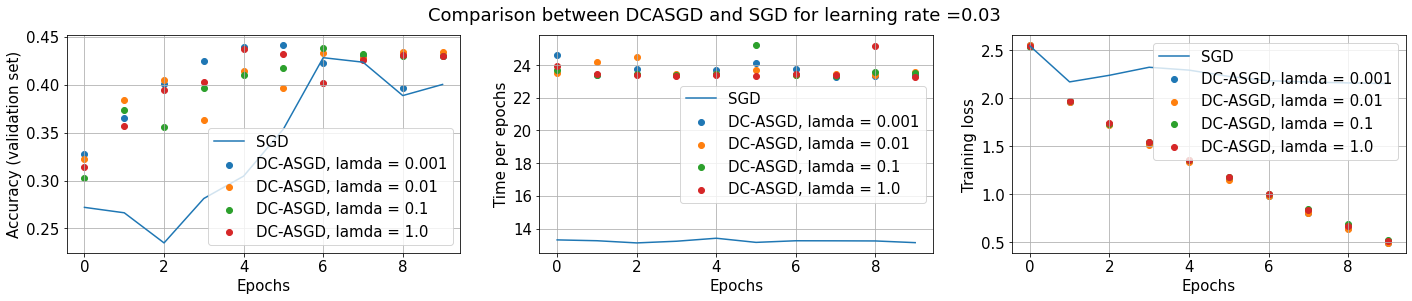

<Figure size 1728x288 with 0 Axes>

In [ ]:
comparison(epochs, cifar_train, cifar_valid, batch_size,net, lr = 0.03, lamdas = np.logspace(-3,0,4), momentum=0.0, num_workers=8, folder = "CIPHAR")

### A brief comment on the momentum parameter :
This parameter has been a problem for us. Ultimately, we set it equal to zero as any other value led to computation errors in the ASGD algorithm, and not in the SGD algorithm. Hence, to ensure fairness of comparison, we set it to zero. This choice was also motivated by this [paper](https://arxiv.org/abs/2005.06728), which argues that the momentum parameter does not play a crucial role. 